# Fit and Evaluate XGBoost Model with patient specific features

In this experiment we want to evaluate the change of the model performance if we considere patient specific features. Besides that, we want to evaluate their feature importance.

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### 1. Helping Functions

In [2]:
def train_test_val_split(df):
    # split the data val, test, train
    val_patients = pd.read_csv("data/patients/val_patients_1.csv", index_col=[0]).reset_index(drop=True)
    test_patients = pd.read_csv("data/patients/test_patients_1.csv", index_col=[0]).reset_index(drop=True)
    
    df_val = df[df["patient_id"].isin(val_patients.iloc[:, 0])].reset_index(drop=True)
    df_test = df[df["patient_id"].isin(test_patients.iloc[:, 0])].reset_index(drop=True)
    df_train = df[~(df["patient_id"].isin(set(val_patients.iloc[:, 0]) | set(test_patients.iloc[:, 0])))].reset_index(drop=True)
    return df_val, df_test, df_train

In [3]:
def create_splits(df_train, df_test, df_val, features, patient_features=[], time_slice=0):
    data_split = {}
    for split in ["val", "test", "train"]:
        
        data_split[f"X_{split}"] = eval(f"df_{split}")[[f"{feature}_{time_slice}" for feature in features] + patient_features]
        data_split[f"y_{split}"] = eval(f"df_{split}")[["seizure"]]
    return data_split["X_train"], data_split["y_train"], data_split["X_test"], data_split["y_test"], data_split["X_val"], data_split["y_val"]

In [4]:
def get_best_params(X_train, y_train):
    model = XGBClassifier()

    # Define the hyperparameter grid for grid search
    param_grid = {
        'objective': ['binary:logistic'],
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.5, 0.1, 0.01],
        'max_depth': [3, 5, 7],
        'scale_pos_weight':[0.1, 0.2, 0.9, 0.5],
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

    # Fit the data to perform grid search
    grid_search.fit(X_train, y_train)  # X_train and y_train are your training data

    # Print the best hyperparameters and the corresponding score
    print("Best Hyperparameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

In [5]:
# fit xgboost model
def fit_and_eval(X_train, y_train, X_test, y_test):
    # Define initial hyperparameters
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        #'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

    # Create the XGBoost classifier
    model = XGBClassifier(**params)

    # Train the XGBoost model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # return evaluation
    return model, (accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred),recall_score(y_test, y_pred),recall_score(y_test, y_pred, pos_label=0))

In [6]:
def get_correlation_dict(correlations, coefficient=0.8):
    correlation_dict = {}
    for index, row in correlations.iterrows():
        correlated_features = []
        for feature, value in row.items():
            if index != feature and value >= coefficient:
                correlated_features.append(feature)
        correlation_dict[index] = correlated_features

    return correlation_dict

In [7]:
def get_permutation_importance_dict(correlation_dict, X_train, X_test, X_val, y_train, y_test, y_val):
    params = {
            'objective': 'binary:logistic',  # Binary classification objective
            'learning_rate': 0.1,  # Learning rate
            'max_depth': 7, # Maximum depth of each tree
            'n_estimators': 300,
            'subsample': 0.8,  # Subsample ratio of the training instances
            'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
            'scale_pos_weight': 0.9,
        }

    permutation_importance_dict = {}

    for key, value in correlation_dict.items():
        X_train_f = X_train.drop(columns=value)

        if X_test is not None and X_val is not None:
            X_test_f = X_test.drop(columns=value)
            X_val_f = X_val.drop(columns=value)
        
        # Create the XGBoost classifier
        model = XGBClassifier(**params)

        # Train the XGBoost model
        model.fit(X_train_f, y_train)

        if X_test is not None and X_val is not None:
            df_perm = perm_importance(model, pd.concat([X_val_f, X_test_f]), pd.concat([y_val,y_test]))
        else:
            df_perm = perm_importance(model, X_train, y_train)

        permutation_importance_dict[key] = df_perm[df_perm.feature == key].perm_importance
    
    return permutation_importance_dict

In [8]:
features = {'avg',
 'csi',
 'csi_filtered',
 'csi_filtered_slope',
 'csi_slope',
 'csim',
 'csim_filtered',
 'csim_filtered_slope',
 'csim_slope',
 'cvi',
 'hf',
 'hr_diff',
 'hr_diff_filtered',
 'hr_diff_filtered_slope',
 'hr_diff_slope',
 'kurt',
 'lf',
 'lf_hf_ratio',
 'mf_coef_center',
 'mf_coef_left',
 'mf_coef_right',
 'mf_hurst_max',
 'nnx',
 'pnnx',
 'quantile_25',
 'quantile_50',
 'quantile_75',
 'rmssd',
 'rmssd_dt',
 'sd',
 'sd1',
 'sd2',
 'skew',
 'total_power',
 'triangular_index',
 'ulf',
 'variance',
 'vlf'
 }

## 2. Modelling using patient data

### 2.1 Using Age and Sex

In [9]:
# load data
df = pd.read_csv("prep_patient_data.csv", index_col=[0])

Columns (2097,2099,2100,2105) have mixed types. Specify dtype option on import or set low_memory=False.


In [10]:
# filter out birthday of "1900-01-01"
df = df[~(df["birthday"] == "1900-01-01")]

In [11]:
# rename column
df = df.rename(columns={"window_Unnamed: 2093_level_1": "window"})
    
# filter for a starting window of zero
df = df[df["window"] == 0]

In [12]:
# get dummy variables for sex
df = pd.concat([pd.get_dummies(df.sex), df], axis=1).drop(columns="sex")

In [13]:
# train test val split (only considere first timeslice)
df_val, df_test, df_train = train_test_val_split(df)
X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, ["age", "f", "m", "u"], 0)

In [14]:
# get best model parameters
#get_best_params(X_train, y_train)

In [ ]:
# fit model
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, pd.concat([X_test, X_val]),  pd.concat([y_test, y_val]))

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [ ]:
cm

array([[248]])

In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



In [15]:
# fit model
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [16]:
cm

array([[248]])

In [17]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



In [18]:
df_feature_importance = pd.DataFrame({
        "features": X_train.columns,
        "importance": model.feature_importances_
    })

In [19]:
df_feature_importance = df_feature_importance.sort_values(by="importance", ascending=False).reset_index(drop=True)

In [20]:
df_feature_importance

,features,importance
0,cvi_0,0.075319
1,sd_0,0.066527
2,csi_0,0.060728
3,csim_0,0.054657
4,triangular_index_0,0.054276
5,pnnx_0,0.048003
6,ulf_0,0.044982
7,total_power_0,0.043743
8,variance_0,0.038956
9,age,0.035594


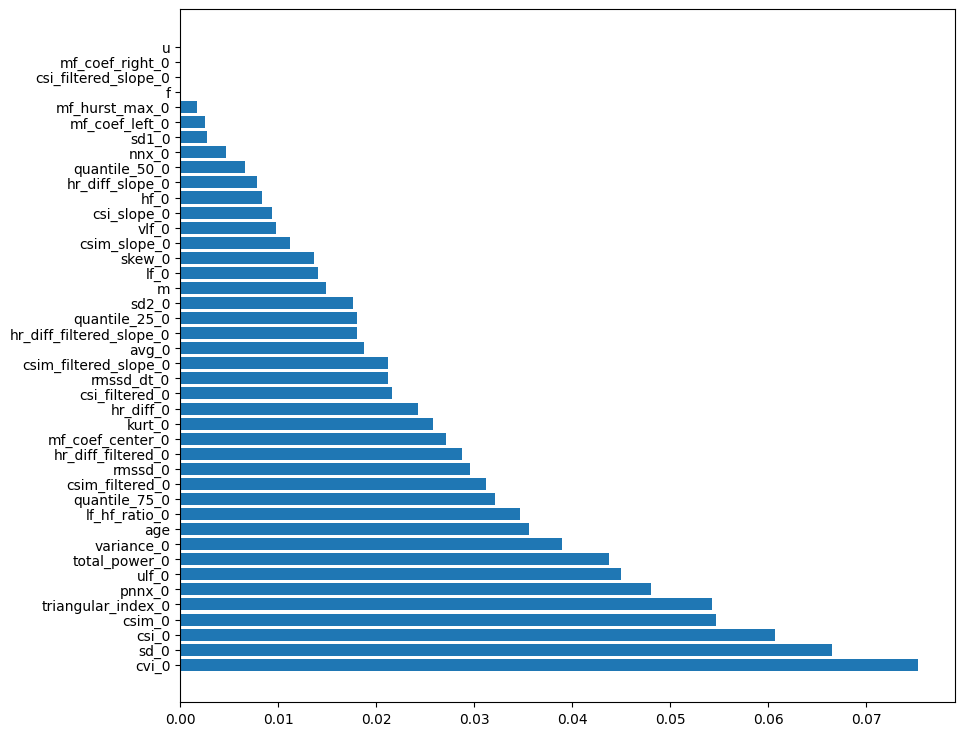

In [21]:
fig, ax = plt.subplots(figsize=(10,9))
ax = plt.barh(df_feature_importance["features"], df_feature_importance["importance"])

In [22]:
def perm_importance(model, X, y):
    perm_importance = permutation_importance(estimator=model, X=X, y=y,scoring="recall", n_repeats=10)
    df_perm_importance = pd.DataFrame(
        {
            "feature": X.columns,
            "perm_importance": perm_importance["importances_mean"]
        }
    ).sort_values(by="perm_importance", ascending=False).reset_index(drop=True)
    return df_perm_importance

In [23]:
df_perm_importance = perm_importance(model, X_train, y_train)

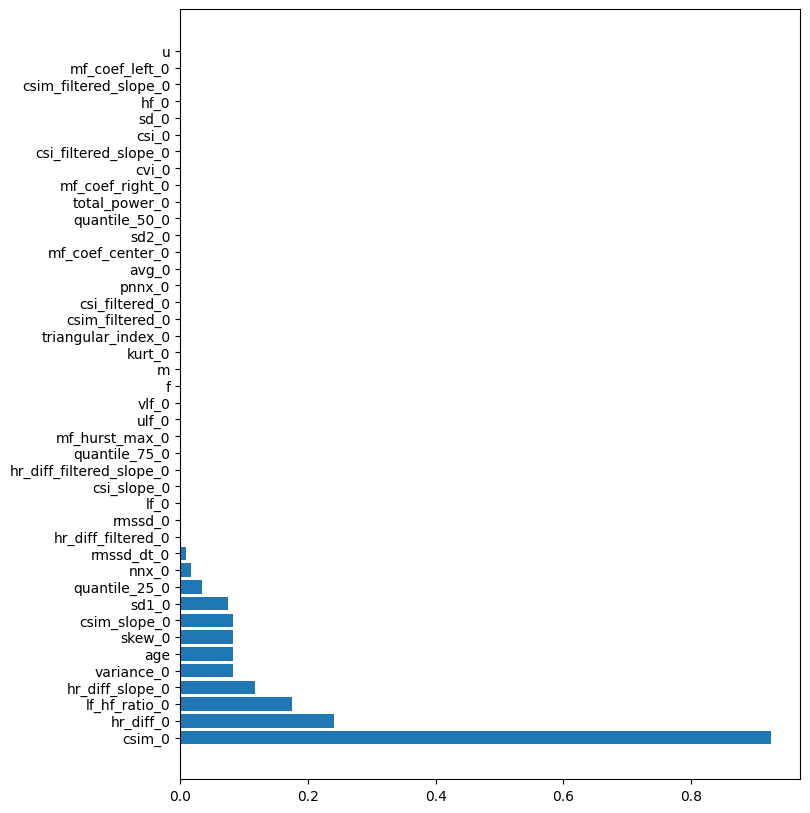

In [24]:
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(df_perm_importance["feature"], df_perm_importance["perm_importance"])

In [25]:
df_perm_importance = perm_importance(model, pd.concat([X_test, X_val]), pd.concat([y_test, y_val]))

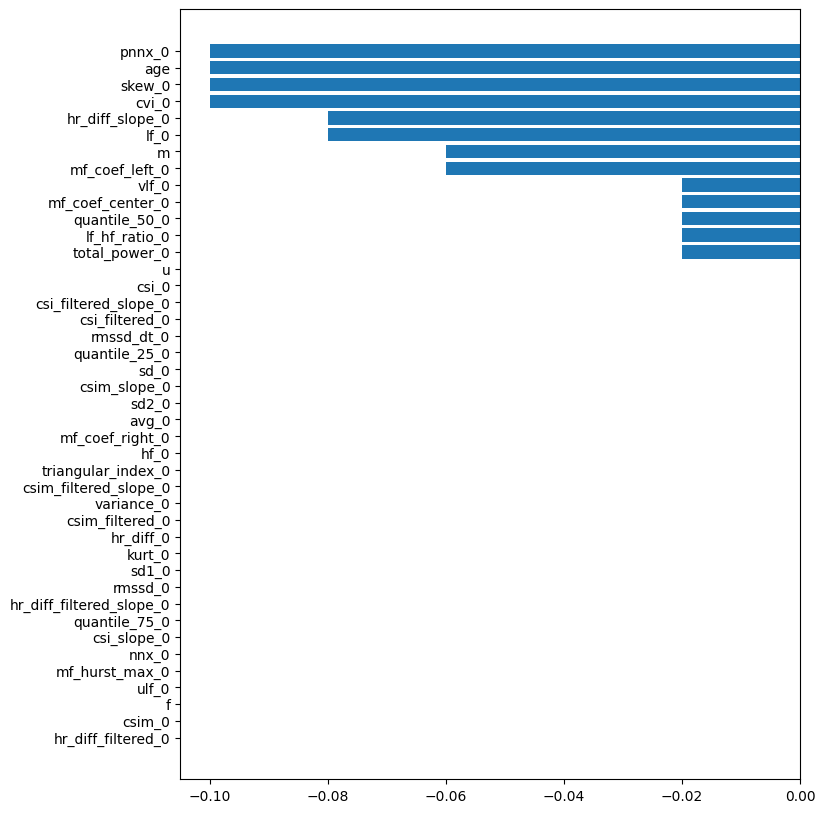

In [26]:
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(df_perm_importance["feature"], df_perm_importance["perm_importance"])

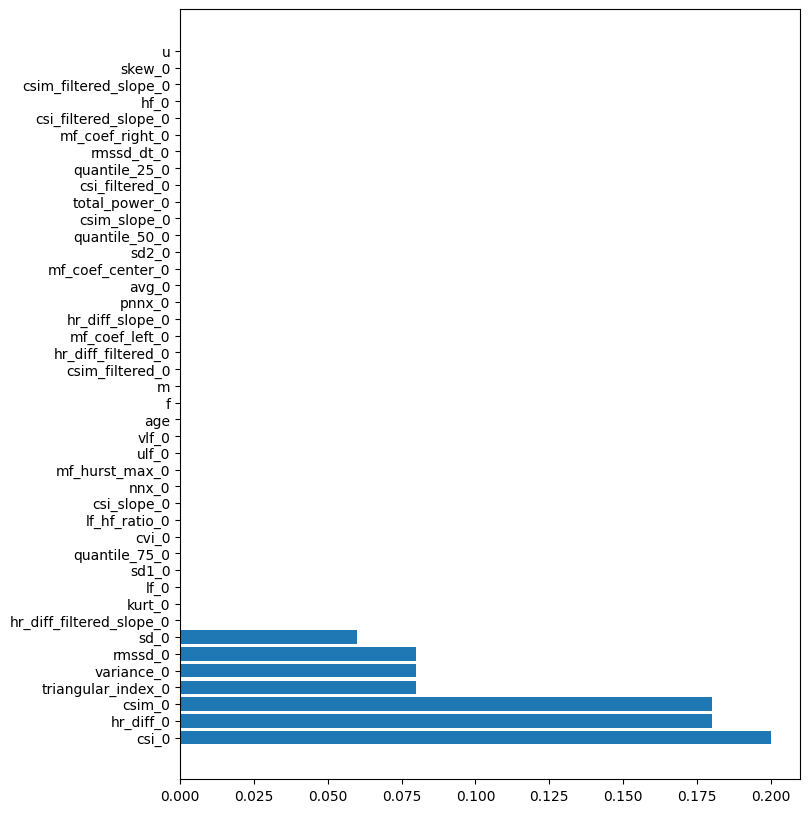

In [27]:
# permutation importance without correlations
correlation_dict = get_correlation_dict(X_train.corr())
permutation_importance_dict =  get_permutation_importance_dict(correlation_dict, X_train, X_test, X_val, y_train, y_test, y_val)

values = []
keys = []
for key, value in permutation_importance_dict.items():
    values.append(value.values[0])
    keys.append(key)
permutation_importance_df = pd.DataFrame({
    "feature": keys,
    "importance": values
})

permutation_importance_df = permutation_importance_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(permutation_importance_df.feature, permutation_importance_df.importance)

In [28]:
# shap feature importance
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [29]:
# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(pd.concat([X_test, X_val]))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


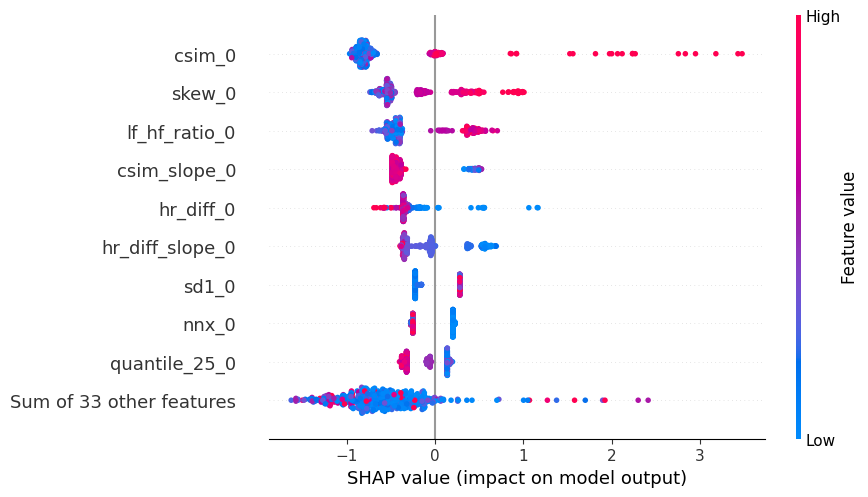

In [30]:
shap.plots.beeswarm(shap_values)

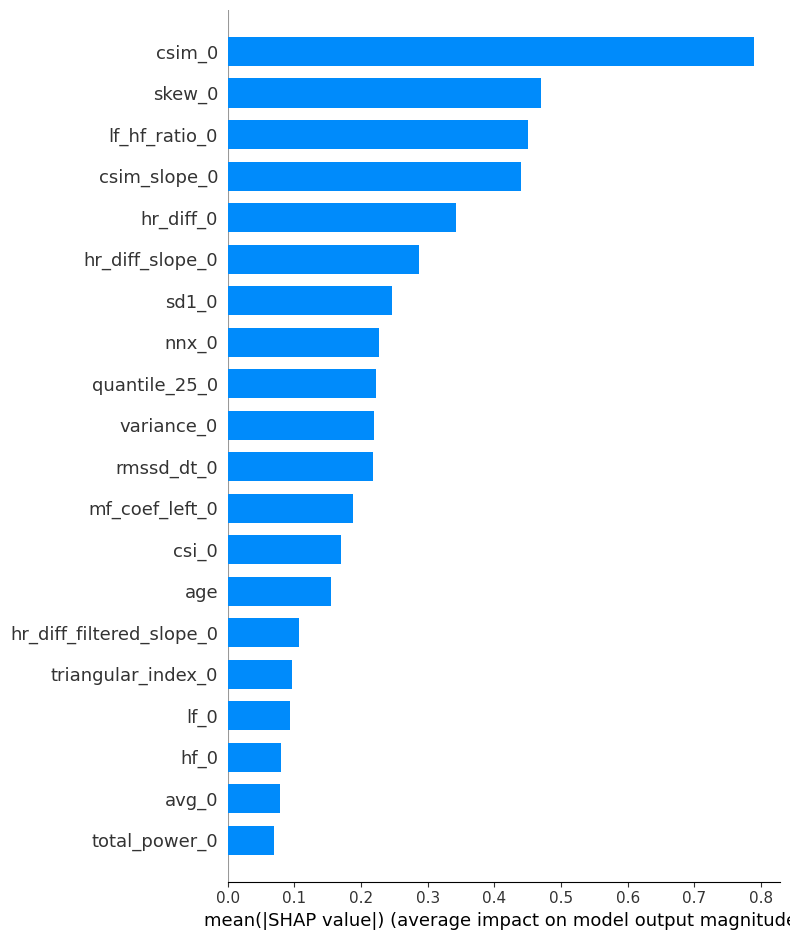

In [31]:

shap.summary_plot(shap_values, pd.concat([X_test, X_val]), plot_type="bar")

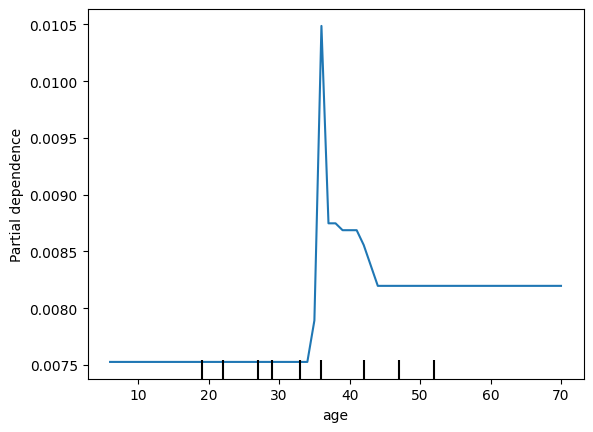

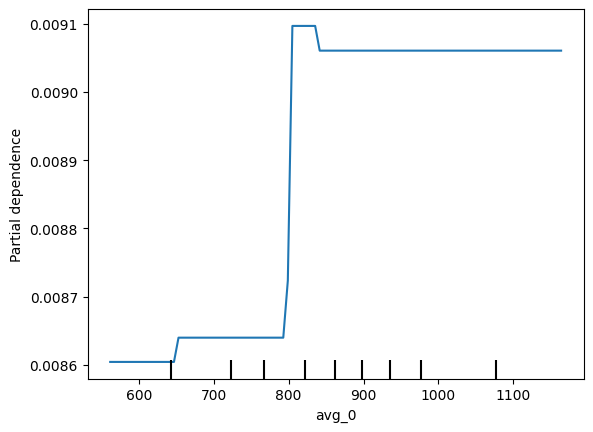

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


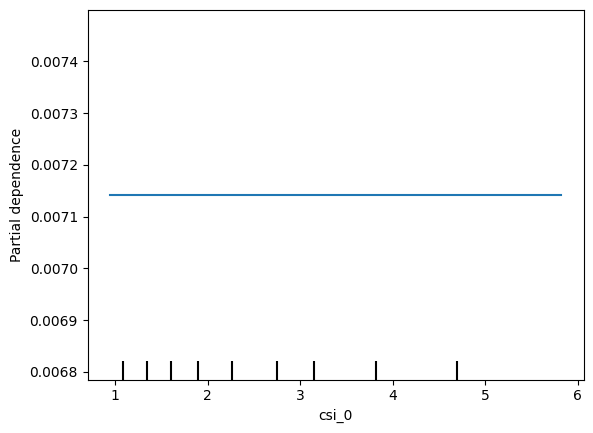

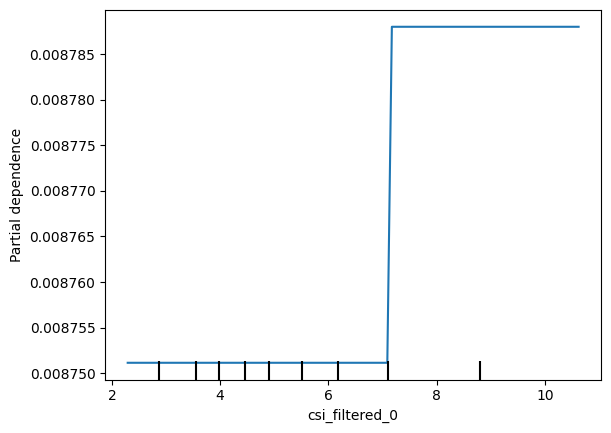

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


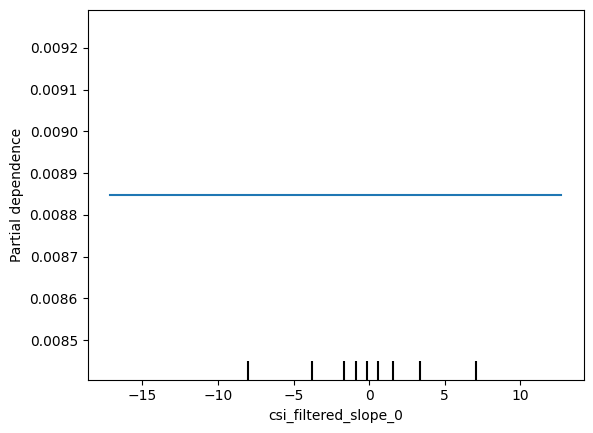

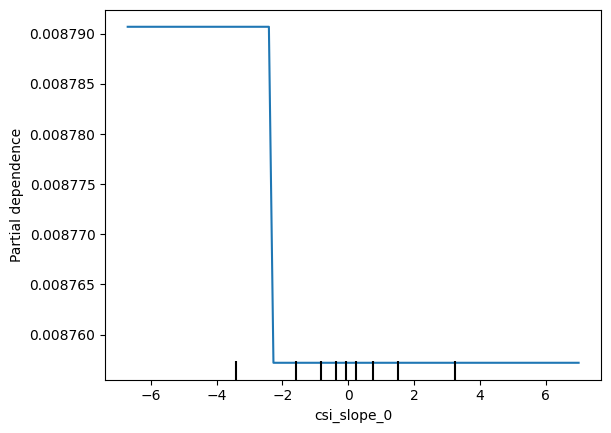

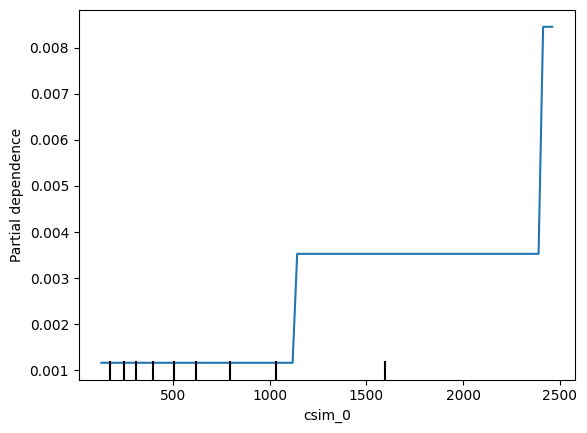

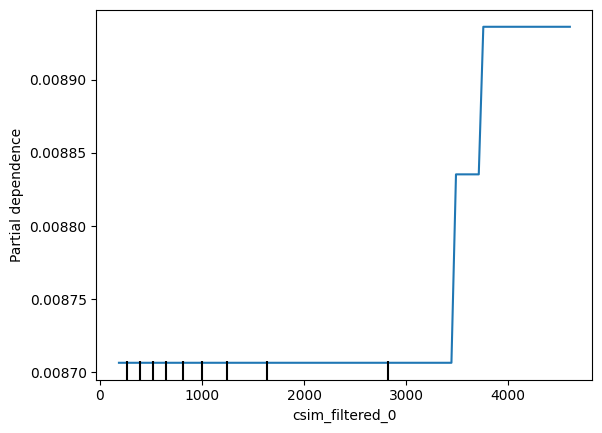

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


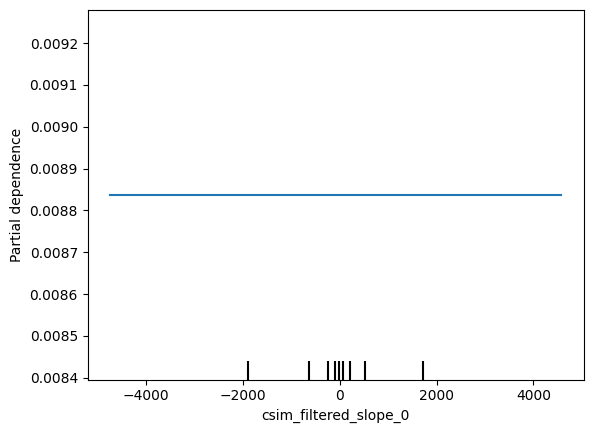

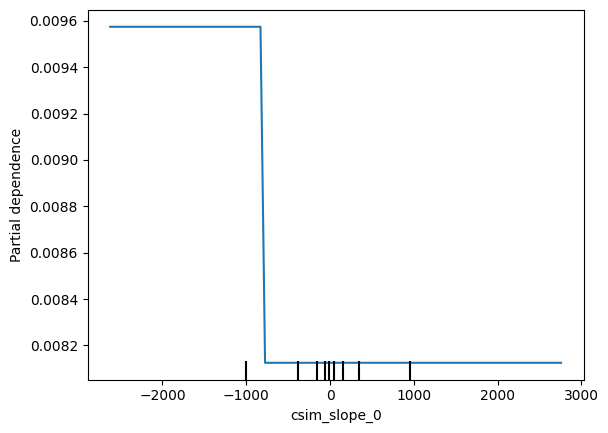

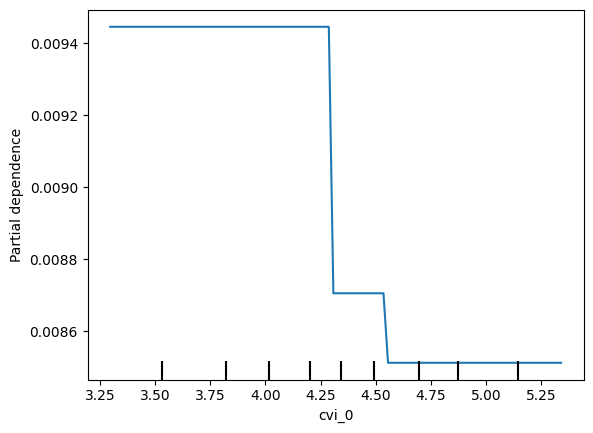

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


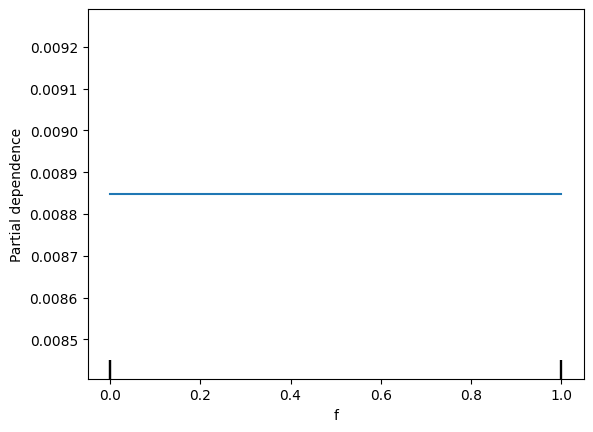

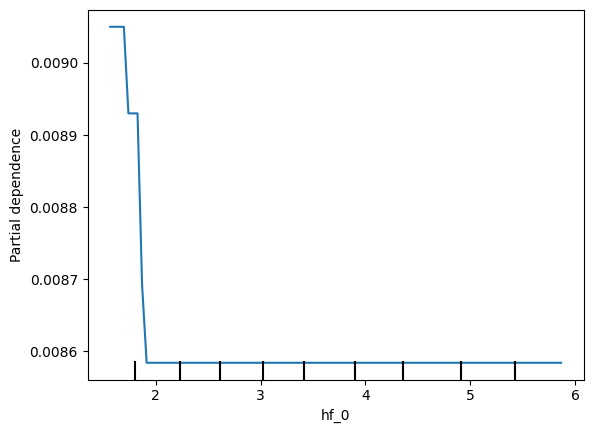

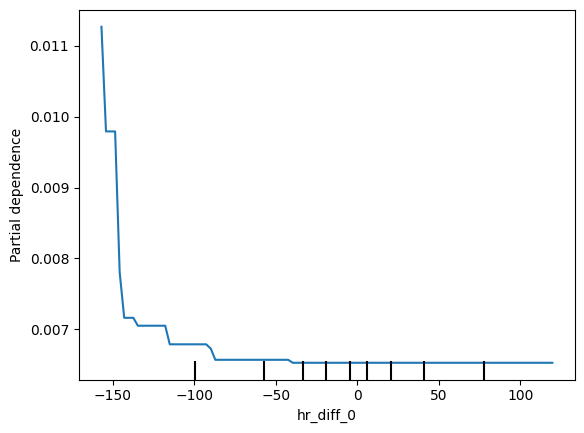

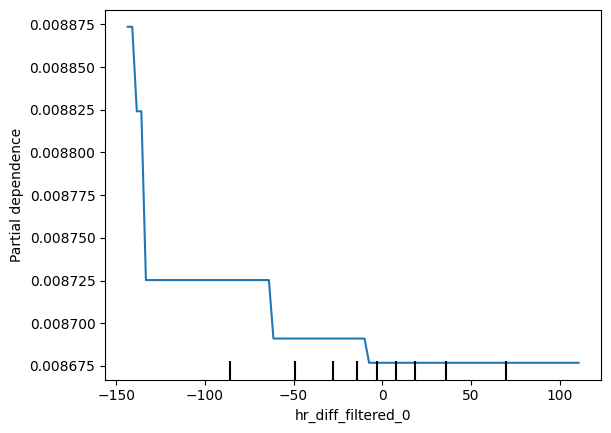

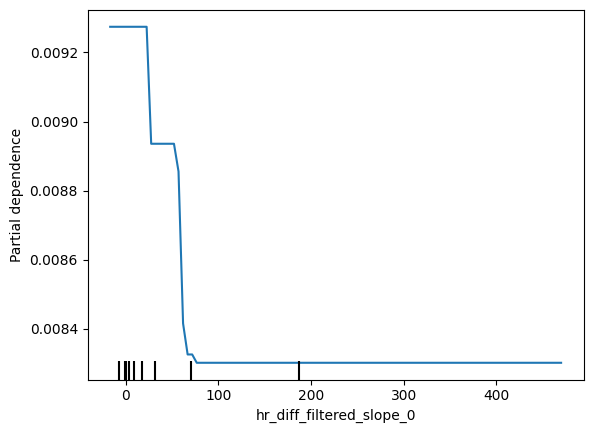

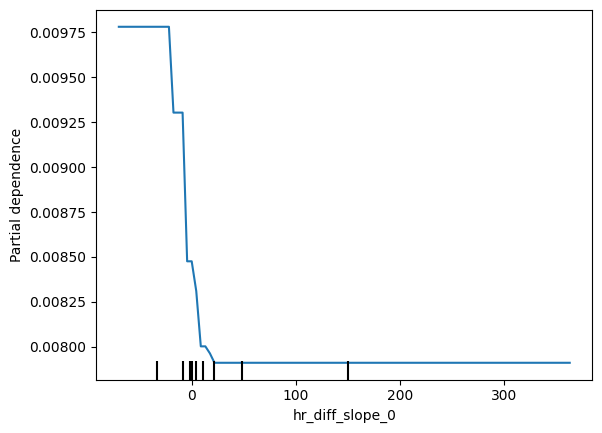

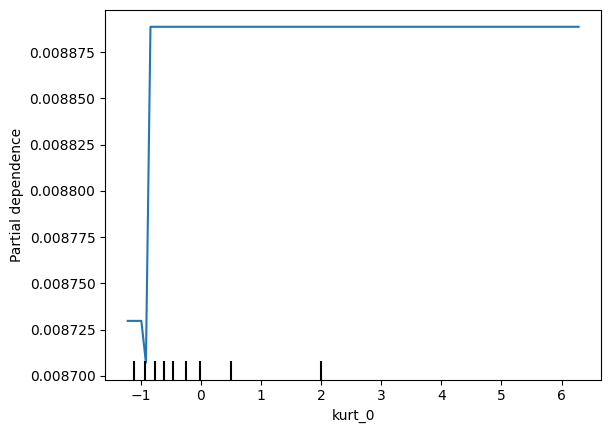

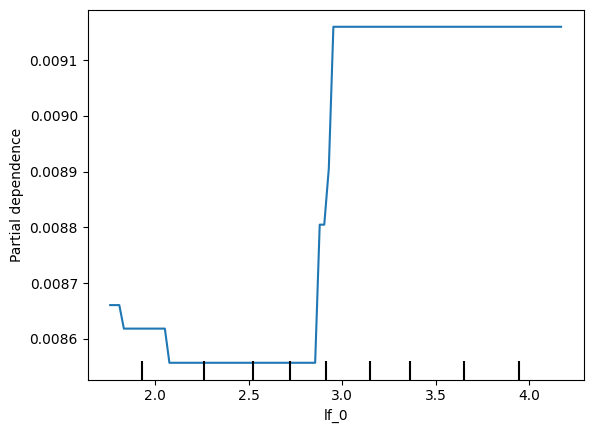

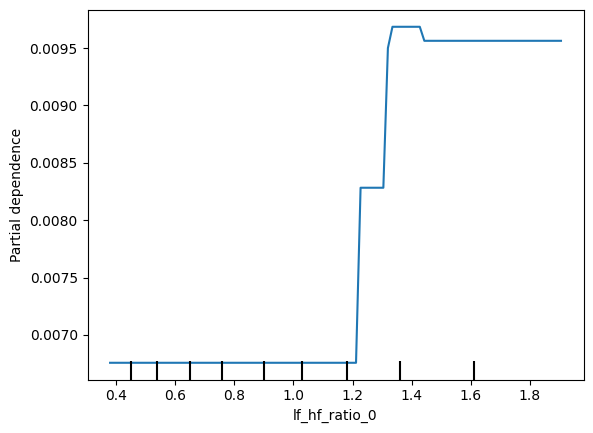

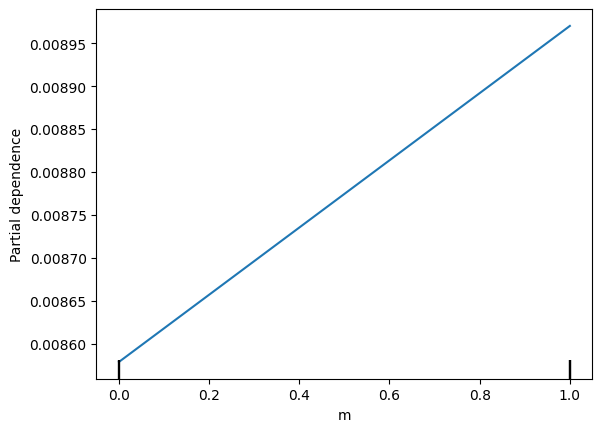

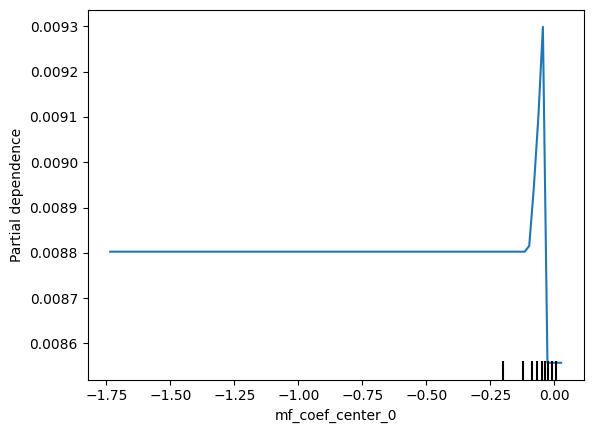

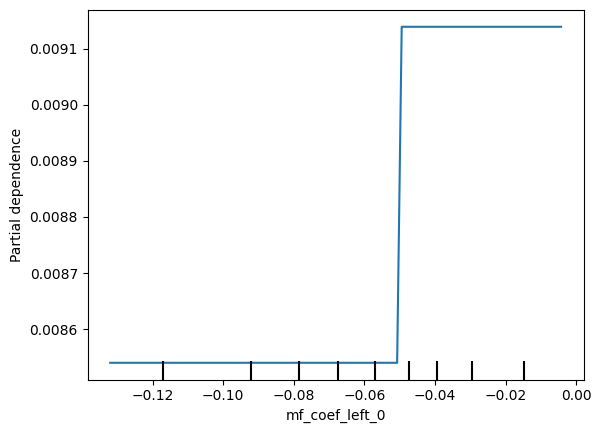

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


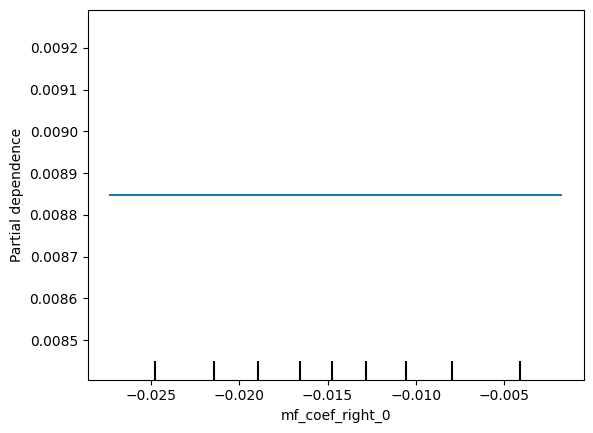

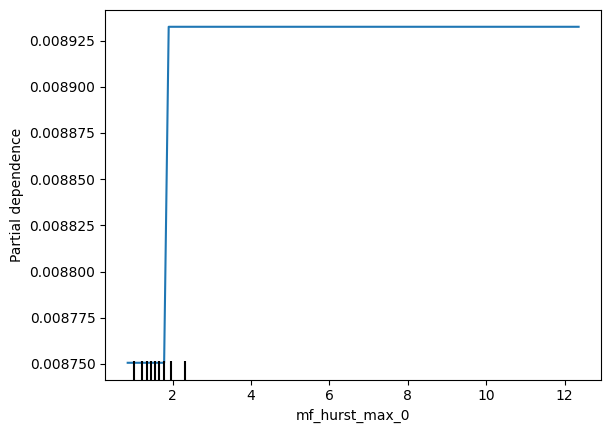

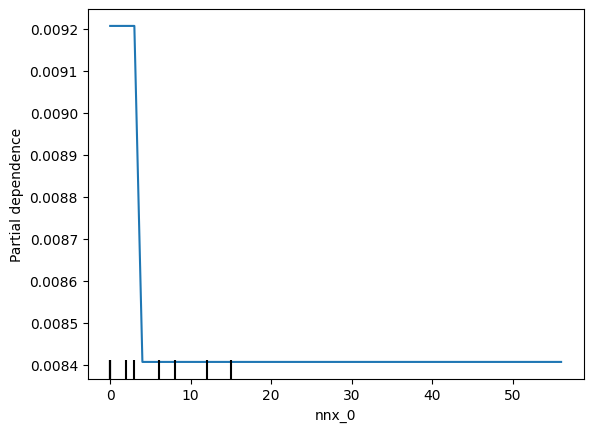

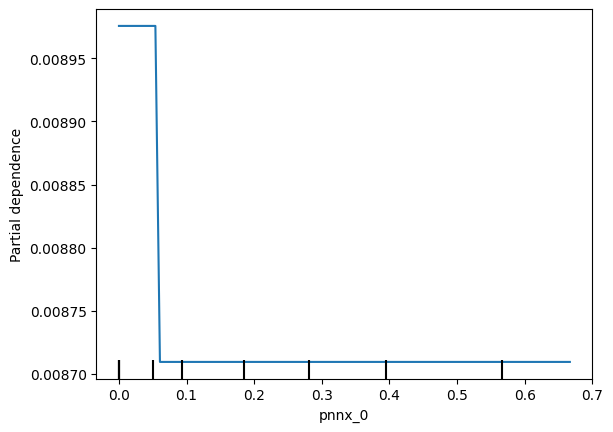

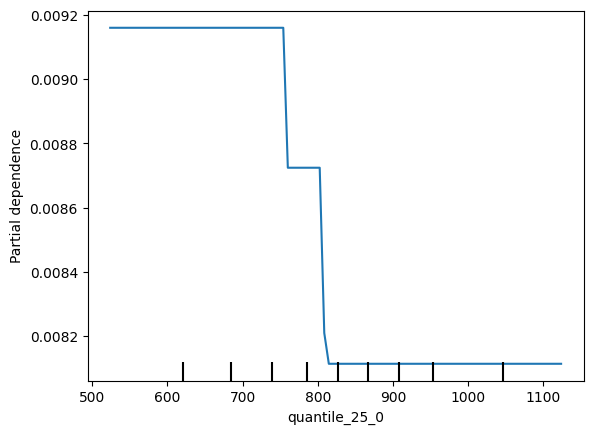

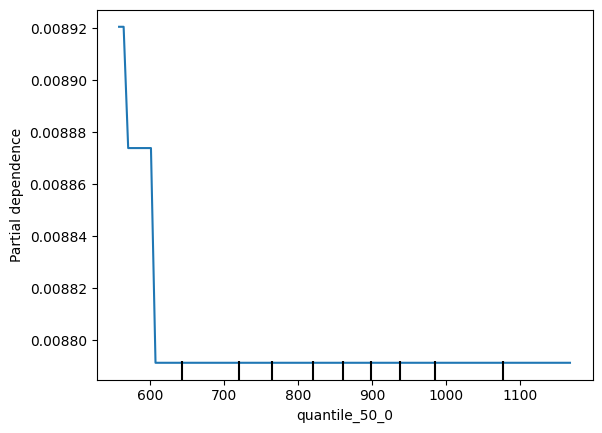

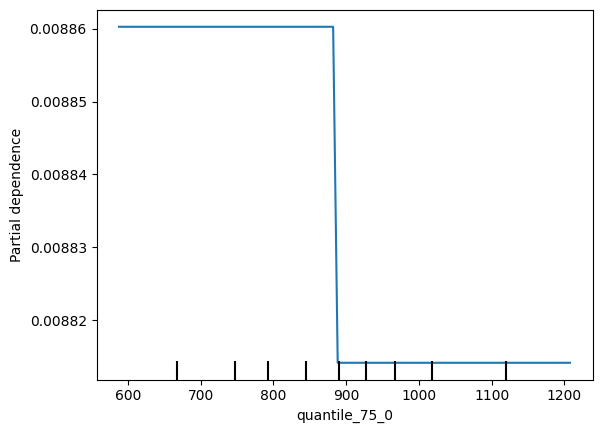

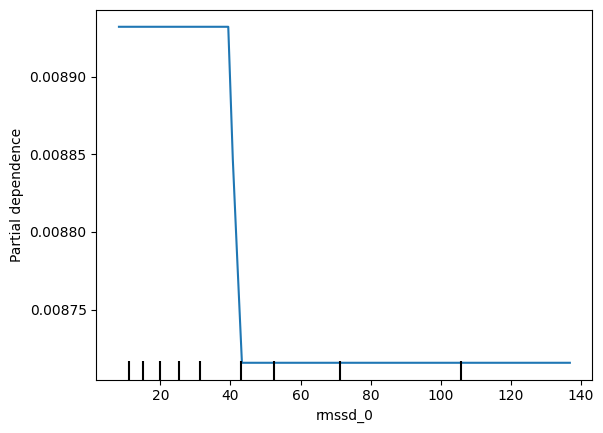

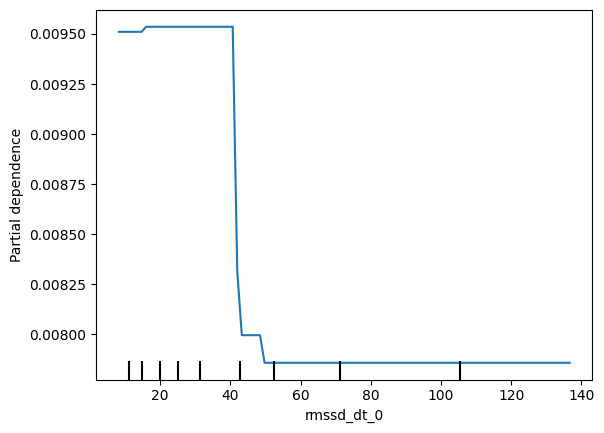

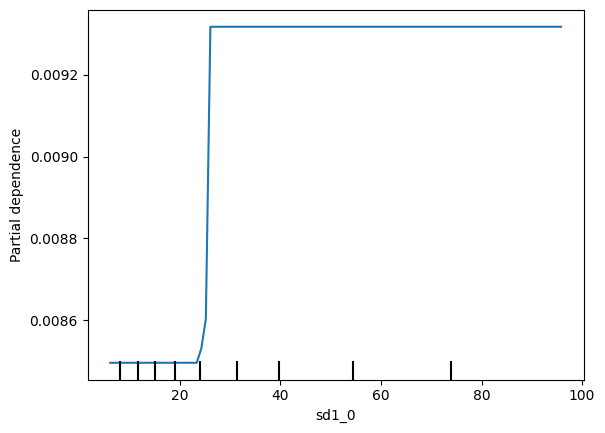

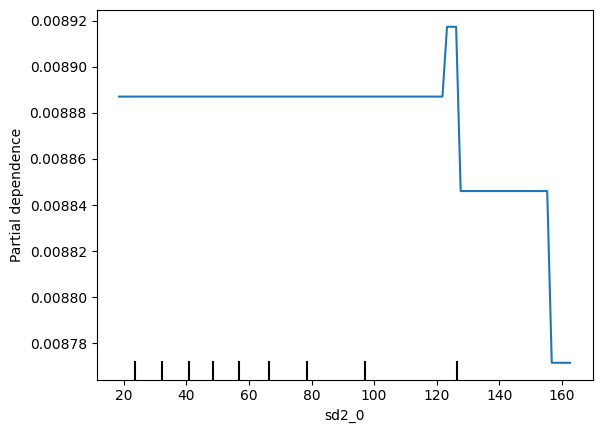

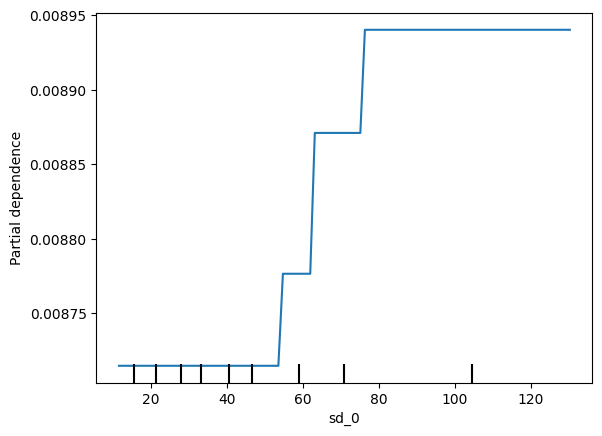

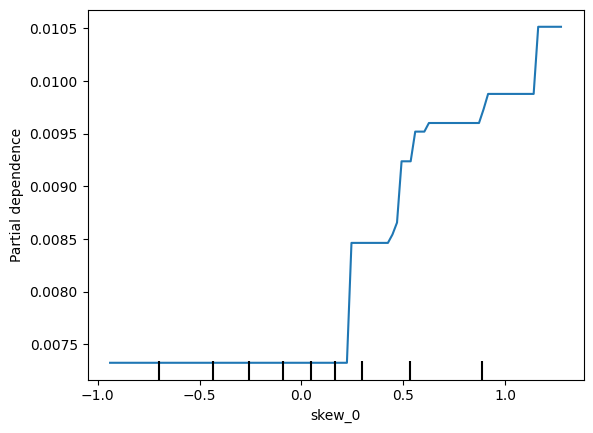

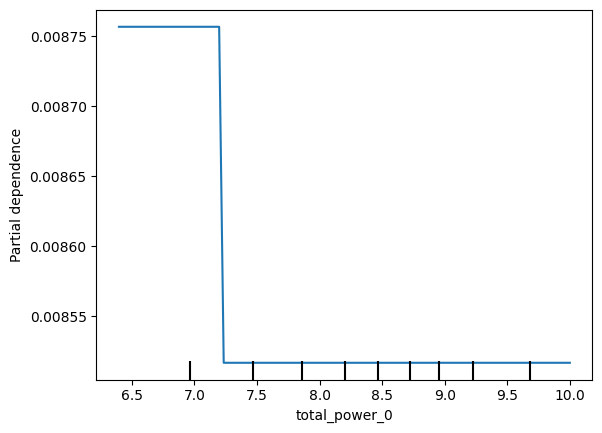

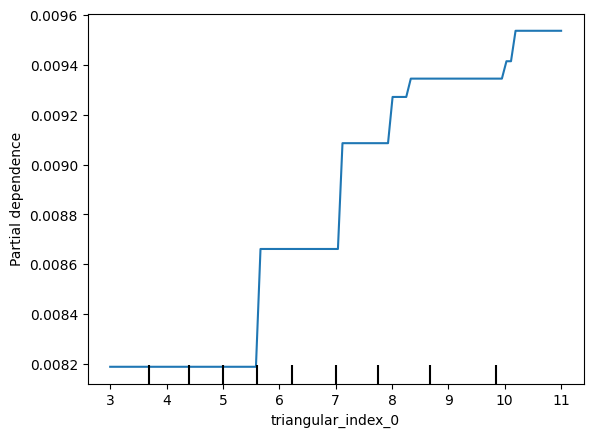

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


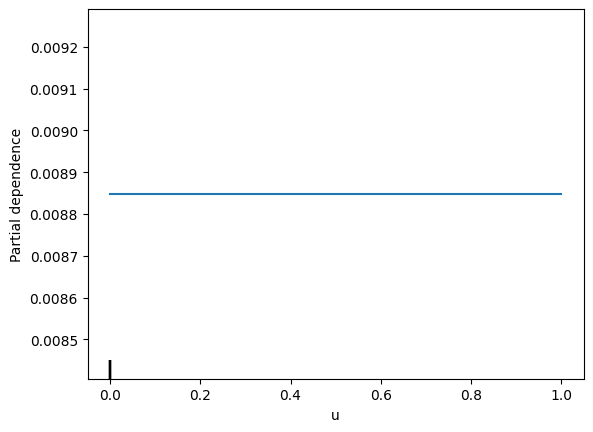

ValueError: percentiles are too close to each other, unable to build the grid. Please choose percentiles that are further apart.

In [32]:
# partial dependency
for feature in sorted(list(X_train.columns)):
    PartialDependenceDisplay.from_estimator(model, X_train, [feature])
    plt.show()


### 2.2 Fit model not using patient specific data (for comparison of the performance)

In [ ]:
# train test val split (only considere first timeslice)
df_val, df_test, df_train = train_test_val_split(df)
X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, [], 0)

In [ ]:
# fit model
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

In [ ]:
print(accuracy)

0.95


In [ ]:
print(cm)

[[258   7]
 [  8  27]]


In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       265
           1       0.79      0.77      0.78        35

    accuracy                           0.95       300
   macro avg       0.88      0.87      0.88       300
weighted avg       0.95      0.95      0.95       300



In [ ]:
# fit model
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, pd.concat([X_test, X_val]),  pd.concat([y_test, y_val]))

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [ ]:
cm

array([[248]])

In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



### 2.3 Use another split of the data

We want to try of to fit the model only on data which contains a patient on time. We do not want the model to identify the using their patient specific data.

In [ ]:
df

,f,m,u,avg_0,csi_0,csi_filtered_0,csi_filtered_slope_0,csi_slope_0,csim_0,csim_filtered_0,...,firstname,birthday,weight,height,comment,do_ignore,use_for_training,epilepsy_onset,seizure,age
2,True,False,False,598.916687,6.548198,18.058413,-18.937326,-6.866903,1390.509033,3443.171631,...,X,1968-01-01,0,0,NaN,0,1,1,1,40
5,True,False,False,691.166687,3.037296,14.249208,-24.085255,-5.133903,957.971863,3488.913086,...,X,1968-01-01,0,0,NaN,0,1,1,1,40
8,True,False,False,612.361694,4.478743,12.549462,-3.134268,-1.118580,1373.817139,3004.185059,...,X,1968-01-01,0,0,NaN,0,1,1,1,40
11,True,False,False,482.566681,4.030056,7.819622,1.011127,0.521112,459.405212,788.141541,...,X,1968-01-01,0,0,NaN,0,1,1,1,40
14,True,False,False,676.904785,4.776184,15.245516,-20.104975,-6.298577,1477.992798,3856.273682,...,X,1968-01-01,0,0,NaN,0,1,1,1,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,False,False,True,1065.963013,1.531682,4.880877,0.130987,0.041105,199.782974,531.186279,...,NaN,1980-01-23,0,0,NaN,0,0,-1,0,32
440,False,False,True,1046.500000,1.052647,4.372571,4.647161,1.118752,196.339737,605.092529,...,NaN,1980-01-23,0,0,NaN,0,0,-1,0,32
443,False,False,True,836.676453,5.583738,6.675104,4.608039,3.854634,1956.223145,2078.288574,...,NaN,1966-03-31,85,185,Darüber hinaus Fälle von veränderten Empfindun...,0,0,-1,0,48
446,False,False,True,894.419373,2.657282,8.202579,15.645937,5.068609,633.976318,1813.514404,...,NaN,1966-03-31,85,185,Darüber hinaus Fälle von veränderten Empfindun...,0,0,-1,0,48


In [ ]:
patient_id_list = df.patient_id.unique()

In [ ]:
df_unique_patients = pd.DataFrame()
for patient_id in patient_id_list:
    df_unique_patients = pd.concat([df[df["patient_id"] == patient_id].sample(1, replace=True), df_unique_patients])

In [ ]:
df_unique_patients.seizure.sum()

46

In [ ]:
X = df_unique_patients[[f"{feature}_{0}" for feature in features] + ["age", "f", "m", "u"]]
y = df_unique_patients[["seizure"]]

In [ ]:
X

,nnx_0,mf_coef_right_0,rmssd_dt_0,csi_slope_0,pnnx_0,csim_filtered_0,mf_coef_center_0,quantile_25_0,vlf_0,mf_coef_left_0,...,skew_0,hr_diff_slope_0,mf_hurst_max_0,lf_0,triangular_index_0,rmssd_0,age,f,m,u
326,2.0,-0.007226,18.691051,-3.987663,0.052632,1851.833130,-0.023596,720.50,2.611000,-0.056161,...,0.538618,-2.419481,1.738302,2.093881,4.333333,18.721645,39,False,False,True
320,1.0,-0.008920,18.257439,-3.452986,0.030303,1402.248535,0.009866,831.00,2.617753,-0.097254,...,0.349434,126.195030,1.889568,3.584649,4.250000,18.236660,28,False,False,True
212,2.0,-0.005477,26.021738,5.068609,0.066667,1813.514404,-0.030307,871.00,2.435795,-0.089227,...,0.655706,-20.028131,1.896286,2.614375,7.750000,26.232931,48,False,False,True
80,0.0,-0.026043,13.593915,0.209848,0.000000,651.354675,-0.059987,923.25,2.615339,-0.062195,...,1.203344,2.491148,1.766468,2.884910,4.285714,13.745218,49,False,False,True
368,1.0,-0.009654,23.433411,-0.180693,0.033333,351.431854,-0.010950,894.00,2.057728,-0.043303,...,-0.481171,4.251623,1.326043,2.957128,5.166667,23.437149,31,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,3.0,-0.012787,29.822580,-0.003291,0.115385,120.452377,-0.025959,1006.00,1.169654,-0.102894,...,-0.109161,0.130324,1.191273,2.119411,4.500000,29.754120,33,False,True,False
3536,0.0,-0.017515,12.513369,0.292266,0.000000,454.854248,-0.093402,533.00,1.202249,-0.091216,...,-0.931415,5.109988,1.897328,4.407876,3.176471,12.526199,50,False,True,False
1586,0.0,-0.021253,6.914459,-0.109071,0.000000,157.730118,-0.028880,914.00,2.225630,-0.065419,...,0.045644,0.898367,1.578515,3.817936,3.444444,6.916165,42,False,True,False
1175,1.0,-0.034744,19.579021,-0.970770,0.027778,853.573608,-0.118037,758.00,1.816944,-0.054067,...,-0.034152,16.893097,1.672603,3.894224,6.166667,19.425070,36,True,False,False


In [ ]:
#check age for variation
X.age.describe()

count    199.000000
mean      36.321608
std       14.326887
min        6.000000
25%       25.000000
50%       35.000000
75%       47.000000
max       81.000000
Name: age, dtype: float64

In [ ]:
# check number of seizures
y.sum()

seizure    46
dtype: int64

In [ ]:
y

,seizure
326,0
320,0
212,0
80,0
368,0
...,...
3047,0
3536,0
1586,0
1175,0


In [ ]:
params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        #'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

# Create the XGBoost classifier
model = XGBClassifier(**params)

# Train the XGBoost model
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
df_feature_importance = pd.DataFrame({
        "features": X.columns,
        "importance": model.feature_importances_
    })

In [ ]:
df_feature_importance = df_feature_importance.sort_values(by="importance", ascending=False).reset_index(drop=True)

In [ ]:
df_feature_importance

,features,importance
0,csim_0,0.413537
1,quantile_75_0,0.070585
2,sd2_0,0.050275
3,sd1_0,0.044448
4,quantile_25_0,0.044369
5,csim_filtered_0,0.034204
6,mf_coef_center_0,0.031232
7,total_power_0,0.029170
8,hr_diff_filtered_0,0.026358
9,csi_0,0.025263


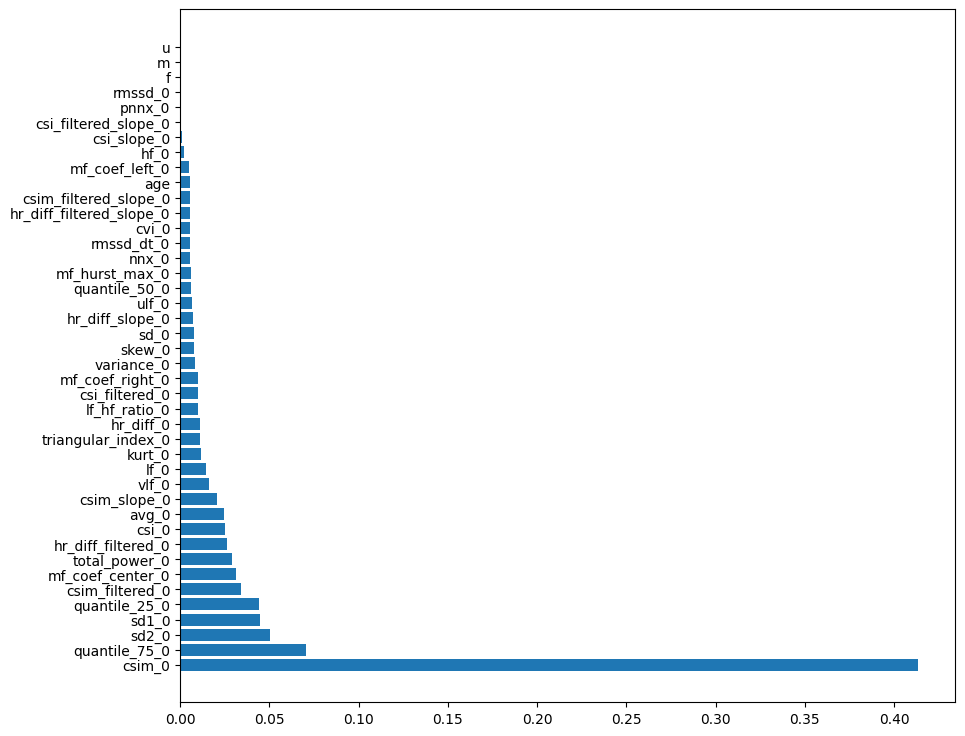

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
ax = plt.barh(df_feature_importance["features"], df_feature_importance["importance"])

In [ ]:
X.shape

(199, 42)

In [ ]:
df_perm_importance = perm_importance(model, X, y)

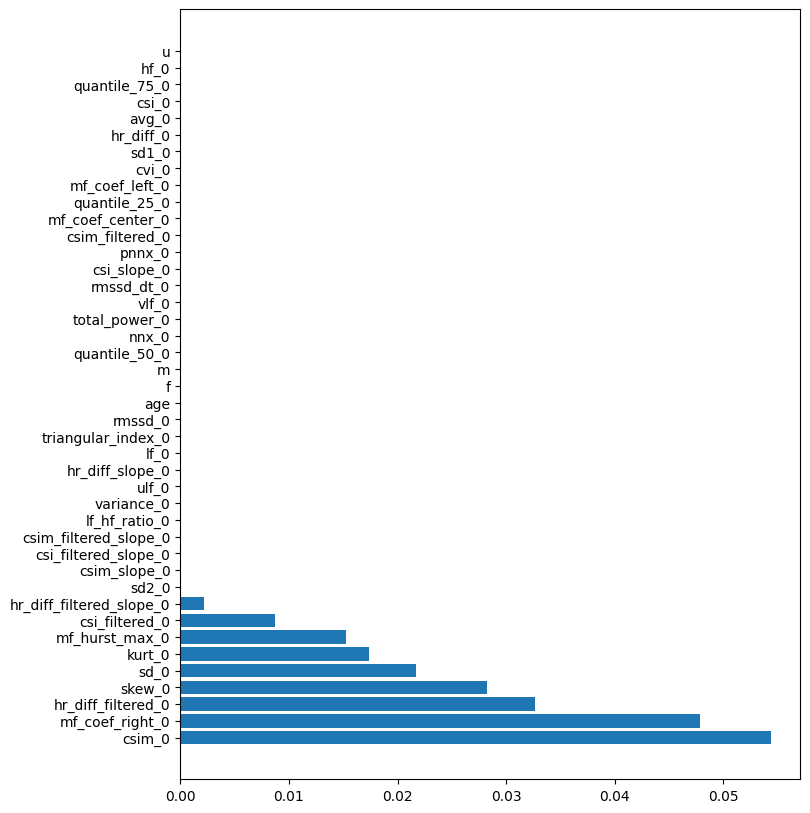

In [ ]:
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(df_perm_importance["feature"], df_perm_importance["perm_importance"])

In [ ]:
# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


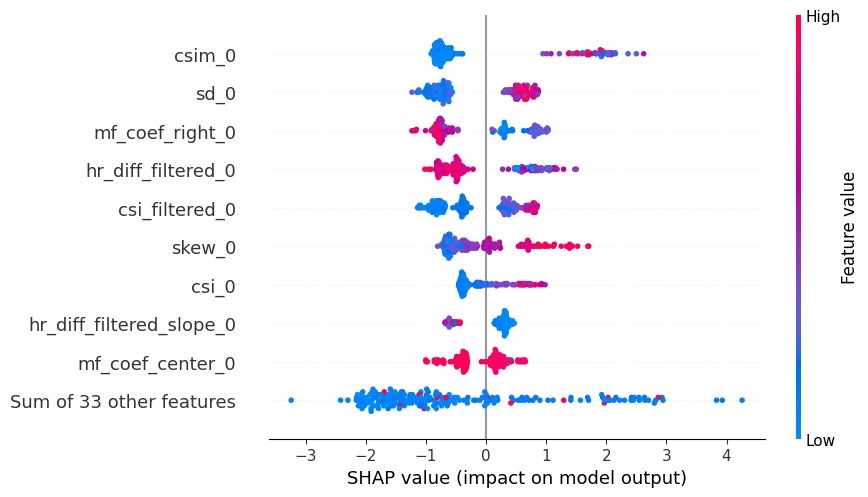

In [ ]:
shap.plots.beeswarm(shap_values)

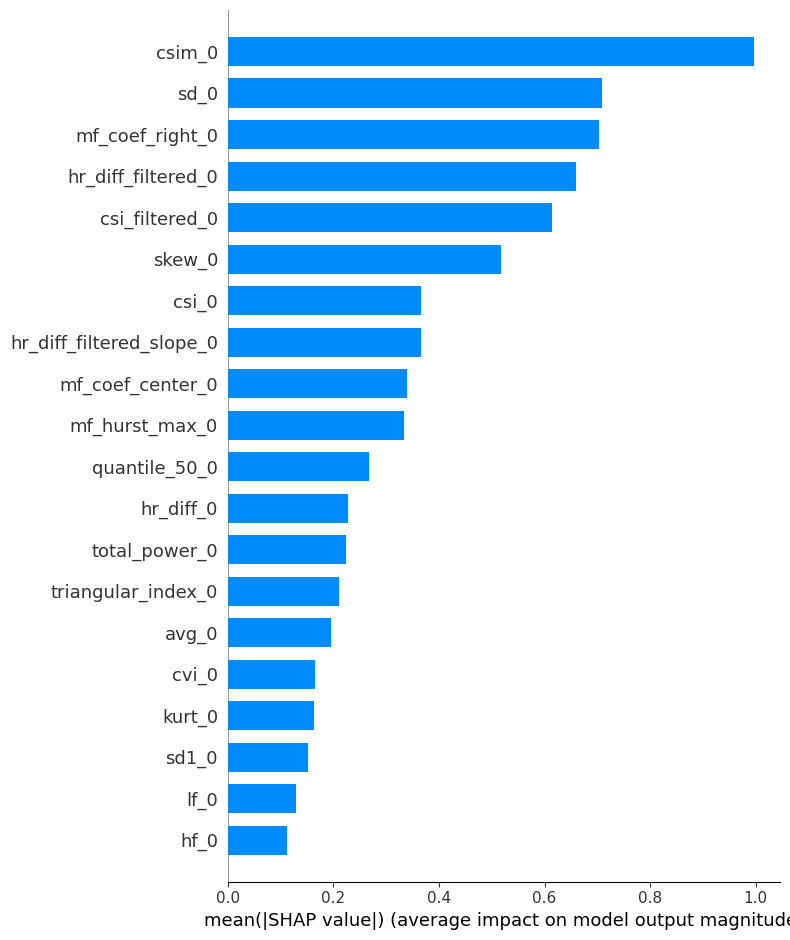

In [ ]:

shap.summary_plot(shap_values, X, plot_type="bar")

### 2.4 Another Split

Now we want to try out how the feature importance changes if we use one seizure and one non-seizure data point for each patient

In [ ]:
df_unique_patients = pd.DataFrame()
for patient_id in patient_id_list:
    if not df[(df["patient_id"] == patient_id) & (df.seizure == 1)].empty:
        df_unique_patients = pd.concat([df[(df["patient_id"] == patient_id) & (df.seizure == 1)].sample(1), df_unique_patients])
    if not df[(df["patient_id"] == patient_id) & (df.seizure == 0)].empty:
        df_unique_patients = pd.concat([df[(df["patient_id"] == patient_id) & (df.seizure == 0)].sample(1), df_unique_patients])

In [ ]:
df_unique_patients.seizure.value_counts()

seizure
0    182
1    102
Name: count, dtype: int64

In [ ]:
X = df_unique_patients[[f"{feature}_{0}" for feature in features] + ["age", "f", "m", "u"]]
y = df_unique_patients[["seizure"]]

In [ ]:
#get_best_params(X, y)

In [ ]:
 params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        #'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

# Create the XGBoost classifier
model = XGBClassifier(**params)

# Train the XGBoost model
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
df_feature_importance = pd.DataFrame({
        "features": X.columns,
        "importance": model.feature_importances_
    })

In [ ]:
df_feature_importance = df_feature_importance.sort_values(by="importance", ascending=False).reset_index(drop=True)

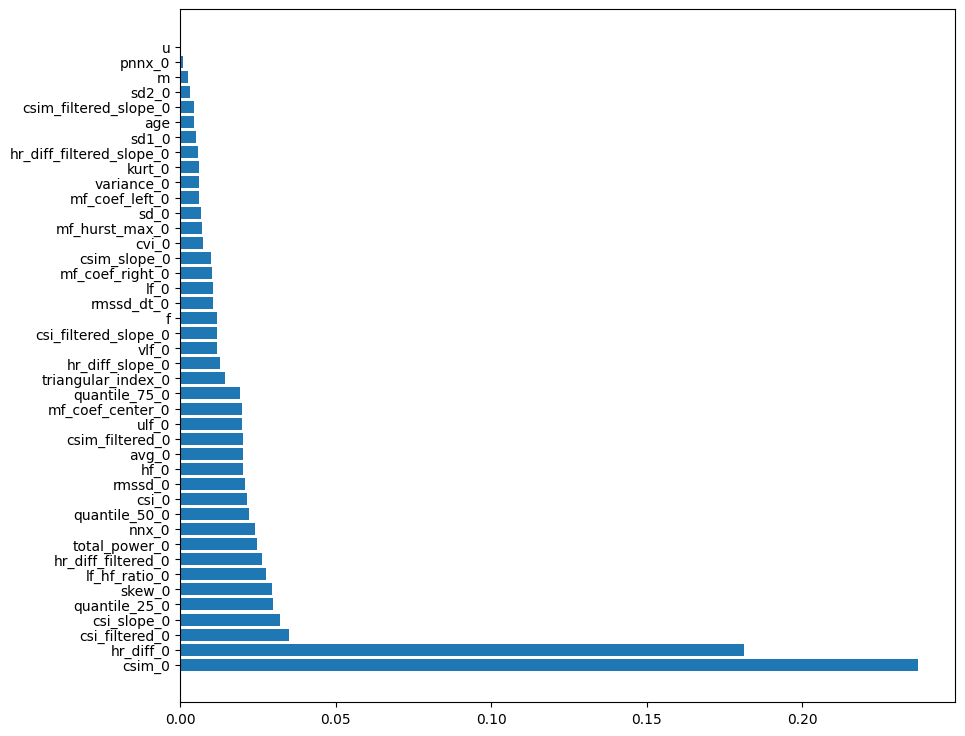

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
ax = plt.barh(df_feature_importance["features"], df_feature_importance["importance"])

In [ ]:
# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


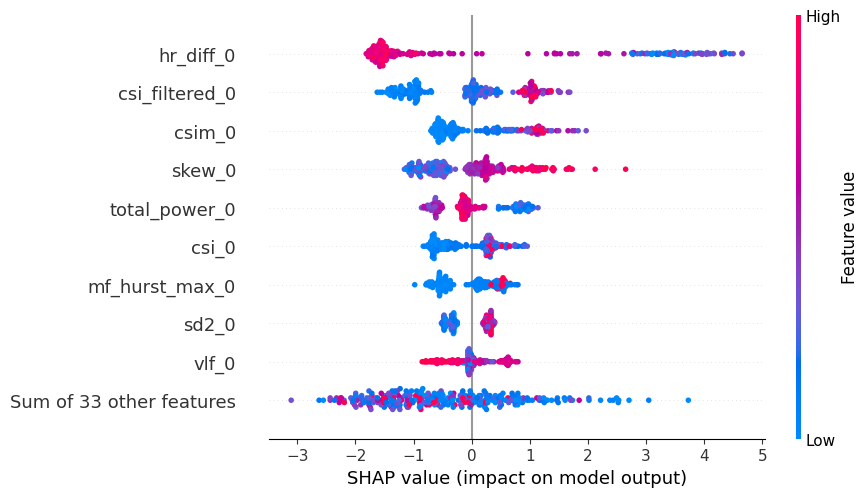

In [ ]:
shap.plots.beeswarm(shap_values)

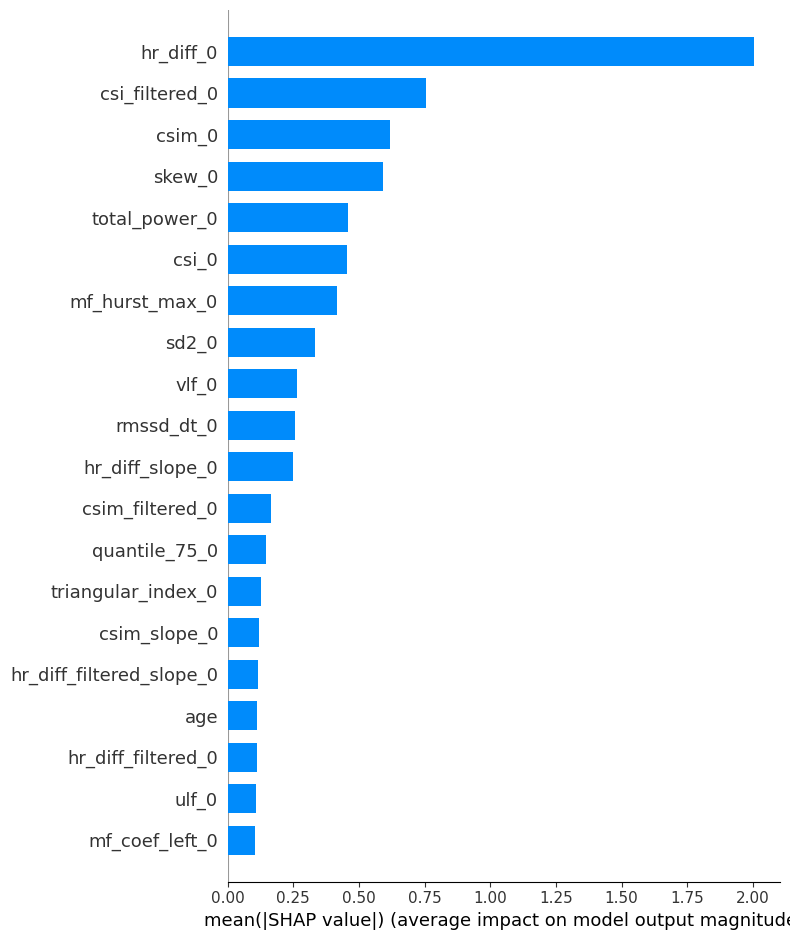

In [ ]:

shap.summary_plot(shap_values, X, plot_type="bar")

### 2.5 Agerange instead of age as feature

In [ ]:
# load data
df = pd.read_csv("prep_patient_data.csv", index_col=[0])

Columns (2097,2099,2100,2105) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
# filter out birthday of "1900-01-01"
df = df[~(df["birthday"] == "1900-01-01")]

In [ ]:
# rename column
df = df.rename(columns={"window_Unnamed: 2093_level_1": "window"})
    
# filter for a starting window of zero
df = df[df["window"] == 0]

In [ ]:
age_ranges = list(range(0, 101, 5))

df['agerange'] = pd.cut(df.age, age_ranges,labels=False, include_lowest = True)

In [ ]:
df[["age", "agerange"]]

,age,agerange
2,40,7
5,40,7
8,40,7
11,40,7
14,40,7
...,...,...
437,32,6
440,32,6
443,48,9
446,48,9


In [ ]:
# get dummy variables for sex
df = pd.concat([pd.get_dummies(df.sex), df], axis=1).drop(columns="sex")

In [ ]:
# train test val split (only considere first timeslice)
df_val, df_test, df_train = train_test_val_split(df)
X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, ["agerange", "f", "m", "u"], 0)

In [ ]:
# fit model
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, pd.concat([X_test, X_val]),  pd.concat([y_test, y_val]))

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [ ]:
cm

array([[248]])

In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



In [ ]:
# fit model
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

In [ ]:
cm

array([[261,   4],
       [  8,  27]])

In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       265
           1       0.87      0.77      0.82        35

    accuracy                           0.96       300
   macro avg       0.92      0.88      0.90       300
weighted avg       0.96      0.96      0.96       300



In [ ]:
# feature importance
df_feature_importance = pd.DataFrame({
        "features": X_train.columns,
        "importance": model.feature_importances_
    })

In [ ]:
df_feature_importance = df_feature_importance.sort_values(by="importance", ascending=False).reset_index(drop=True)

In [ ]:
df_feature_importance

,features,importance
0,csim_0,0.175454
1,hr_diff_filtered_0,0.102536
2,hr_diff_0,0.082179
3,csi_0,0.070144
4,rmssd_0,0.032475
5,rmssd_dt_0,0.032358
6,csi_filtered_0,0.028818
7,pnnx_0,0.027562
8,quantile_25_0,0.026398
9,vlf_0,0.025908


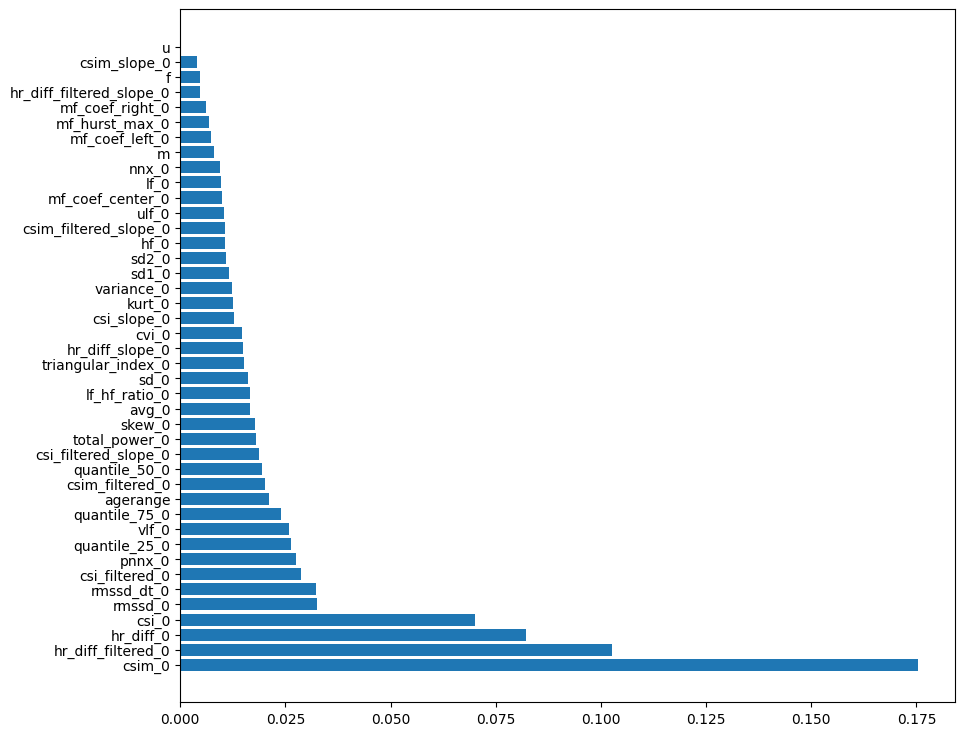

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
ax = plt.barh(df_feature_importance["features"], df_feature_importance["importance"])

In [ ]:
df_perm_importance = perm_importance(model, pd.concat([X_test, X_val]), pd.concat([y_test, y_val]))

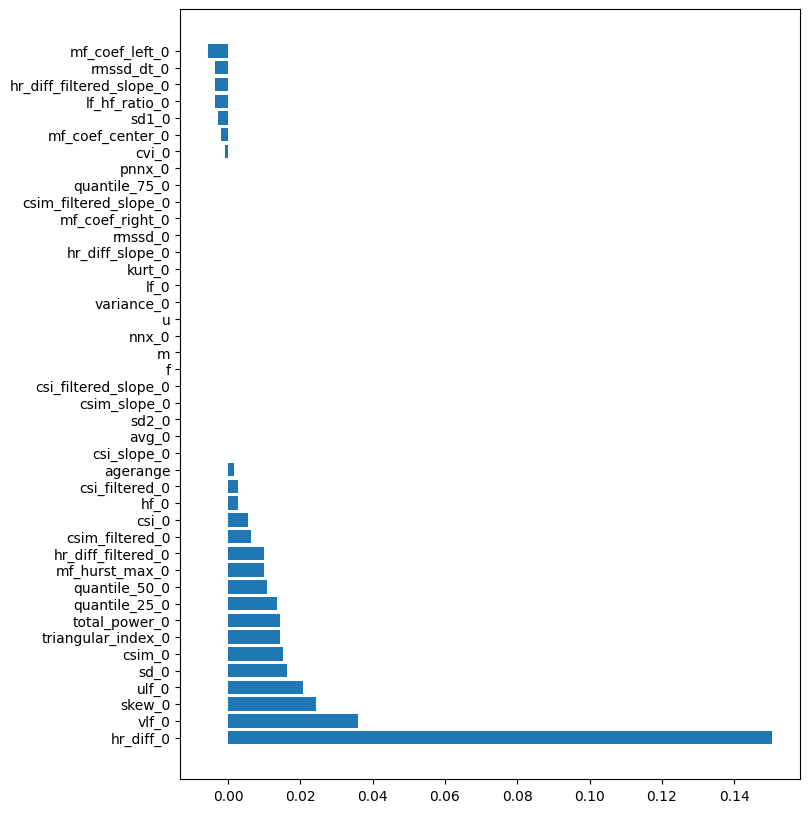

In [ ]:
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(df_perm_importance["feature"], df_perm_importance["perm_importance"])

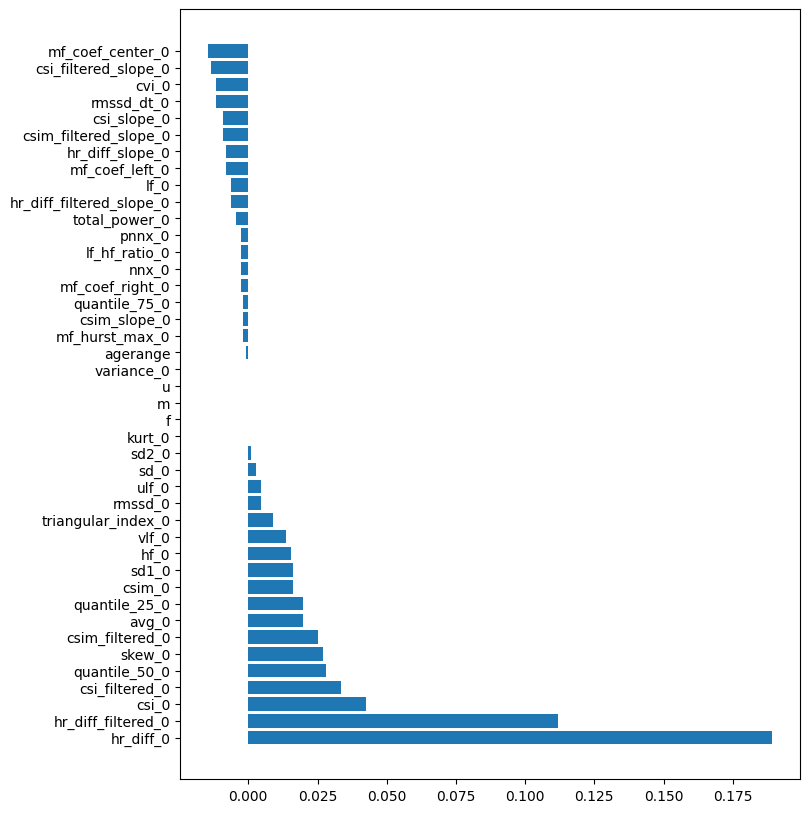

In [ ]:
# permutation importance without correlations
correlation_dict = get_correlation_dict(X_train.corr())
permutation_importance_dict =  get_permutation_importance_dict(correlation_dict, X_train, X_test, X_val, y_train, y_test, y_val)

values = []
keys = []
for key, value in permutation_importance_dict.items():
    values.append(value.values[0])
    keys.append(key)
permutation_importance_df = pd.DataFrame({
    "feature": keys,
    "importance": values
})

permutation_importance_df = permutation_importance_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(permutation_importance_df.feature, permutation_importance_df.importance)

In [ ]:
# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(pd.concat([X_test, X_val]))

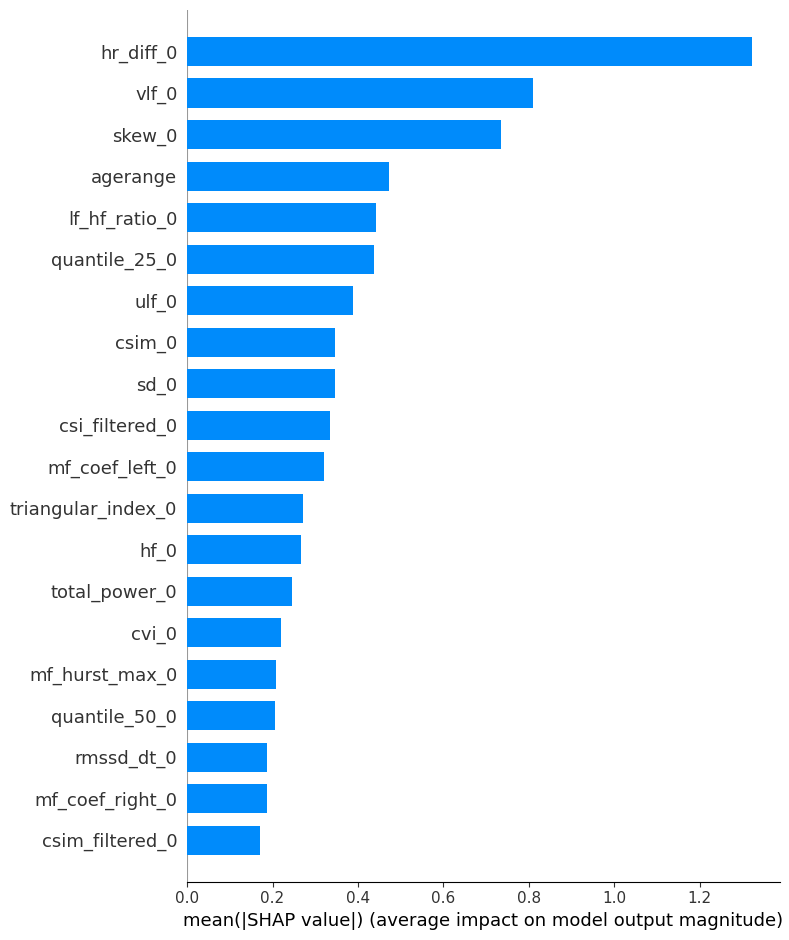

In [ ]:

shap.summary_plot(shap_values, pd.concat([X_test, X_val]), plot_type="bar")

## 3.1 Weight and Height

In [ ]:
# load data
df = pd.read_csv("prep_patient_data.csv", index_col=[0])

Columns (2097,2099,2100,2105) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
# filter out birthday of "1900-01-01"
#df = df.drop(df[df.birthday == "1900-01-01"].index, axis=0)

In [ ]:
# rename column
df = df.rename(columns={"window_Unnamed: 2093_level_1": "window"})
    
# filter for a starting window of zero
df = df[df["window"] == 0]

In [ ]:
df = df[df.weight != 0]

In [ ]:
df = df[df.height != 0]

In [ ]:
X = df[[f"{feature}_{0}" for feature in features] + ["height", "weight"]]
y = df[["seizure"]]

In [ ]:
 params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        #'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

# Create the XGBoost classifier
model = XGBClassifier(**params)

# Train the XGBoost model
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
df_feature_importance = pd.DataFrame({
        "features": X.columns,
        "importance": model.feature_importances_
    })

In [ ]:
df_feature_importance = df_feature_importance.sort_values(by="importance", ascending=False).reset_index(drop=True)

In [ ]:
df_feature_importance

,features,importance
0,csim_0,0.284451
1,csi_filtered_0,0.051567
2,csi_slope_0,0.047129
3,pnnx_0,0.043563
4,csi_0,0.040597
5,sd2_0,0.031488
6,quantile_25_0,0.030169
7,vlf_0,0.030100
8,hr_diff_filtered_0,0.027684
9,sd_0,0.024823


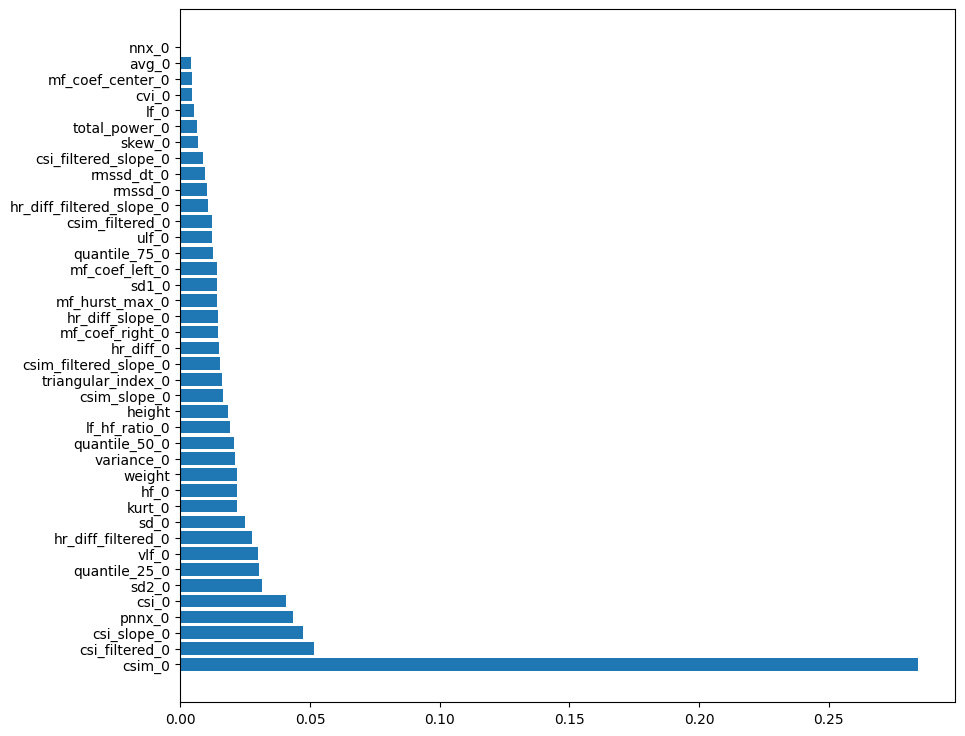

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
ax = plt.barh(df_feature_importance["features"], df_feature_importance["importance"])

In [ ]:
def perm_importance(model, X, y):
    perm_importance = permutation_importance(estimator=model, X=X, y=y,scoring="recall", n_repeats=10)
    df_perm_importance = pd.DataFrame(
        {
            "feature": X.columns,
            "perm_importance": perm_importance["importances_mean"]
        }
    ).sort_values(by="perm_importance", ascending=False).reset_index(drop=True)
    return df_perm_importance

In [ ]:
df_perm_importance = perm_importance(model, X, y)

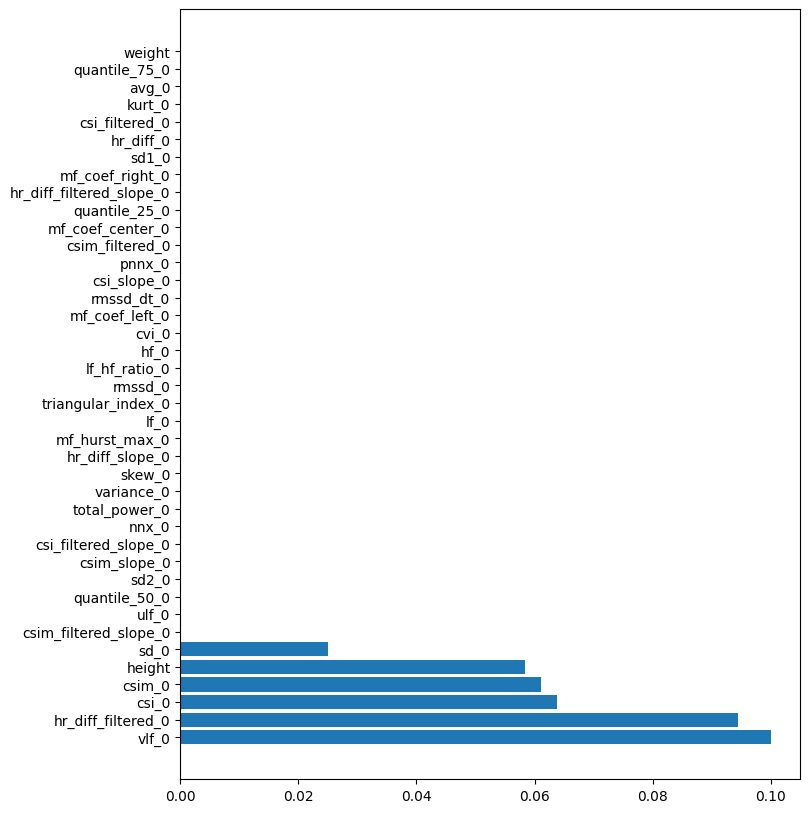

In [ ]:
fig, ax = plt.subplots(figsize=(8,10))
ax = plt.barh(df_perm_importance["feature"], df_perm_importance["perm_importance"])

In [ ]:
# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


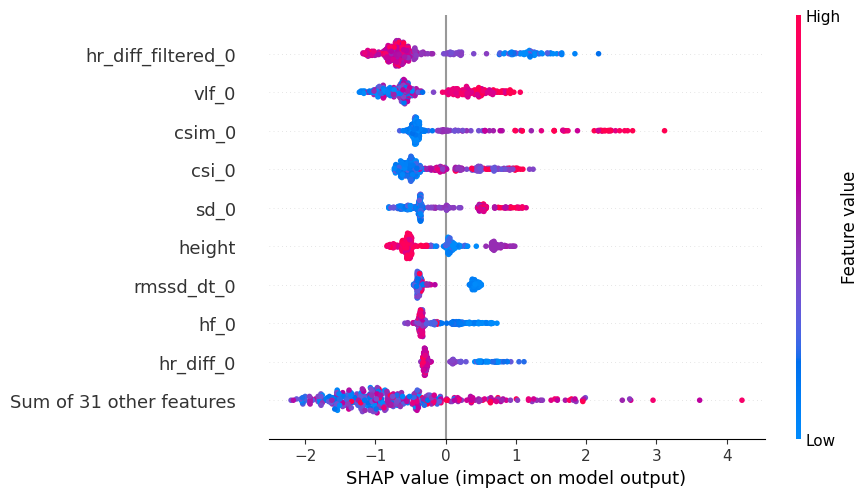

In [ ]:
shap.plots.beeswarm(shap_values)

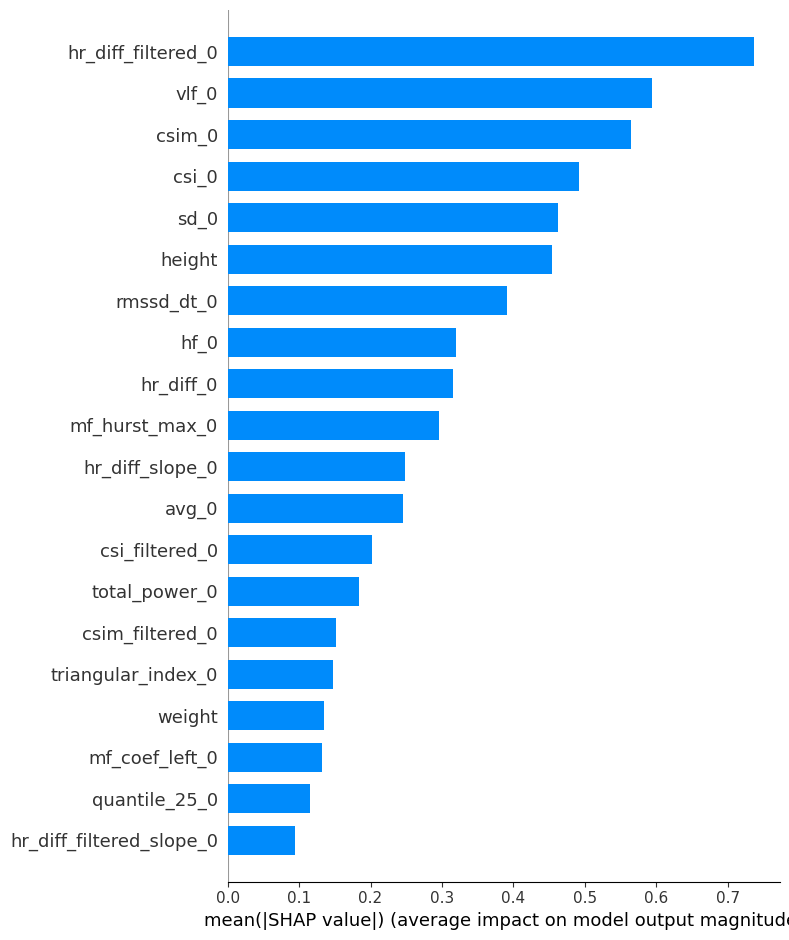

In [ ]:

shap.summary_plot(shap_values, X, plot_type="bar")